# Análisis de los titulares del periódico El País sobre Pedro Sánchez

Según comentaba Pedro Sánchez en la entrevista realizada por Jordi Évole en 'Salvados', el periódico El País fue uno de los poderes que motivaron su dimisión como secretario general del PSOE. 
![Pedro Sánchez con Jordi Évole](http://imagenes.lainformacion.com/2016/10/31/politica/Pedro-Sanchez-Evole-interrogatorios-Salvados_967714282_116318795_667x375.jpg "Pedro Sánchez con Jordi Évole")

> __Los medios han sido especialmente críticos conmigo.__ Yo te digo las advertencias que tuve [por parte de 'El País'] y las consecuencias que hubo.

Analizando los titulares de dos períodos concretos de tiempo vamos a tratar de determinar si, efectivamente, el periódico El País tenía una línea editorial que trataba de forma negativa al ex-líder del PSOE.

Los dos períodos a analizar son los siguientes:
- El mes previo a las primeras elecciones generales (diciembre 2015).
- El mes previo a la dimisión de Pedro Sánchez como secretario general del PSOE (octubre 2016).

Importamos las librerías que vamos a utilizar en el análisis:

In [240]:
%matplotlib inline

import feedparser
import pandas as pd
import numpy as np
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Creamos una función que va a scrapear la web del archivo de El País para conseguir los titulares del día especificado.

Cabe señalar que vamos a coger los titulares publicados en la edición de la mañana.

In [3]:
import requests
from bs4 import BeautifulSoup

def elpais_scrapper(year, month, day):
    df_titulos = pd.DataFrame(columns=['Fecha', 'Titular'])
    
    fecha = year + "/" + month + "/" + day
    
    url = "http://elpais.com/hemeroteca/elpais/" + fecha + "/m/portada.html"
    req = requests.get(url)

    # Comprobamos que la petición nos devuelve un Status Code = 200
    statusCode = req.status_code
    
    if statusCode == 200:
        # Pasamos el contenido HTML de la web a un objeto BeautifulSoup()
        html = BeautifulSoup(req.text, "lxml")

        # Obtenemos todos los divs donde estan las entradas
        if year==2016:
            entradas = html.find_all('h2',{'itemprop':'headline'})
        
        else:
            entradas = html.find_all('h1')
            entradas = entradas + html.find_all('h2')
        
        # Recorremos todas las entradas para extraer el título, autor y fecha
        for i,entrada in enumerate(entradas):
            # Con el método "getText()" no nos devuelve el HTML
            titulo = entrada.find('a').getText()

            # Imprimo el Título, Autor y Fecha de las entradas
            df_titulos.loc[len(df_titulos)] = [fecha,titulo]
    
    else:
        print "Status Code %d" %statusCode
    
    return df_titulos

#### Scraping de los titulares

Elecciones del 20 de diciembre de 2015. Cogemos los titulares generados por El País durante ese mes.

In [6]:
titulares2015 = pd.DataFrame()
for i in range(20):
    day = "%02d" % (i+1,)
    titulares_dia = elpais_scrapper("2015","12",day)
    titulares2015 = titulares2015.append(titulares_dia)

titulares2015.head(5)

,Fecha,Titular
0,2015/12/01,El debate de EL PAÍS consolida las opciones de...
1,2015/12/01,Editorial | Ganó el debate
2,2015/12/01,Cataluña | Podemos se queda solo en defensa de...
3,2015/12/01,Corrupción | Las puertas giratorias y la indep...
4,2015/12/01,Empleo | Entre un contrato único y la derogaci...


La renuncia de Pedro Sánchez como secretario general del PSOE se produjo el 30 de octubre de 2016.

Vamos a analizar los titulares de El País durante ese mes.

In [10]:
titulares2016 = pd.DataFrame()
for i in range(30):
    day = "%02d" % (i+1,)
    titulares_dia = elpais_scrapper("2016","10",day)
    titulares2016 = titulares2016.append(titulares_dia)

titulares2016.head(5)

,Fecha,Titular
0,2016/10/01,El PSOE libra la batalla decisiva en su comité...
1,2016/10/01,Las opciones: una gestora o las primarias que ...
2,2016/10/01,El hundimiento socialista es uno de los peores...
3,2016/10/01,Directo | Decenas de manifestantes en la sede ...
4,2016/10/01,Cronología | Las crisis de Pedro Sánchez


#### Filtro de los titulares

Nos quedamos únicamente con las noticias relacionadas con Pedro Sánchez.

In [163]:
# Cogemos el dataset de 2015
# Filtramos las noticias que contienen "Pedro Sánchez" o "Sánchez".
titulares2015_ps = titulares2015[titulares2015['Titular'].str.contains("PSOE|Pedro S|nchez")]

print 'Número de titulares durante el mes anterior a las primeras elecciones:', titulares2015_ps['Titular'].size
titulares2015_ps.head(5)

Número de titulares durante el mes anterior a las primeras elecciones: 22


,Fecha,Titular
5,2015/12/01,Yihadismo | Iglesias rechaza la coalición de P...
10,2015/12/01,Rajoy solo quiere debatir con Pedro Sánchez pa...
19,2015/12/01,"Sánchez, el más mencionado"
65,2015/12/01,"Rivera, Sánchez e Iglesias en El País debate"
2,2015/12/04,El CIS deja fuera del Congreso a fichajes del ...


In [13]:
# Cogemos el dataset de 2016
# Filtramos las noticias que contienen "Pedro Sánchez" o "Sánchez".
titulares2016_ps = titulares2016[titulares2016['Titular'].str.contains("PSOE|Pedro S|nchez")]

print 'Número de titulares durante el mes anterior a la dimisión de Pedro Sánchez:', titulares2016_ps['Titular'].size
titulares2016_ps.head(5)

Número de titulares durante el mes anterior a la dimisión de Pedro Sánchez: 39


,Fecha,Titular
0,2016/10/01,El PSOE libra la batalla decisiva en su comité...
1,2016/10/01,Las opciones: una gestora o las primarias que ...
4,2016/10/01,Cronología | Las crisis de Pedro Sánchez
5,2016/10/01,Editorial | Un PSOE con futuro
28,2016/10/01,"Iglesias, a los críticos del PSOE: “Nos necesi..."


#### Entrenamiento del corpus

Utilizamos el corpus del TASS creado por la Sociedad Española del Procesado del Lenguaje Natural (SEPLN). Este corpus se ha creado a partir de tweets en español.

Nosotros vamos a utilizarlo por 2 razones:
1. Es uno de los corpus más completos que hay para el idioma español.
2. Un titular se puede asimilar aproximadamente a un tweet dado que es una frase corta.

In [24]:
from lxml import objectify

xml = objectify.parse(open('general-tweets-train-tagged.xml'))

#sample tweet object
tass_corpus_train = pd.DataFrame(columns=('content', 'polarity', 'agreement'))
root = xml.getroot()
tweets = root.getchildren()

for i in range(0,len(tweets)):
    tweet = tweets[i]
    row = dict(zip(['content', 'polarity', 'agreement'], 
                   [tweet.content.text, tweet.sentiments.polarity.value.text, tweet.sentiments.polarity.type.text]))
    row_s = pd.Series(row)
    row_s.name = i
    tass_corpus_train = tass_corpus_train.append(row_s)
tass_corpus_train.to_csv('general-tweets-train-tagged.csv', index=False, encoding='utf-8')


Visualizamos el contenido del TASS corpus:

In [51]:
tass_corpus_train.head(5)

,content,polarity,agreement
0,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT
1,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT
2,@marodriguezb Gracias MAR,P,AGREEMENT
3,"Off pensando en el regalito Sinde, la que se v...",N+,AGREEMENT
4,Conozco a alguien q es adicto al drama! Ja ja ...,P+,AGREEMENT


Limpiamos el dataset de aquellos tweets en los que no se ha definido la polaridad o en los que no se ha llegado a un acuerdo acerca de ésta.

In [65]:
tass_corpus = tass_corpus_train.copy()
tass_corpus = tass_corpus.query('agreement != "DISAGREEMENT" and polarity != "NONE"')

tass_corpus.shape

(5013, 3)

Apartamos algunos tweets para poder probar luego el modelo de clasificación.

In [66]:
# Nos quedamos con el 90% para el modelo
tass_corpus_model = tass_corpus[:tass_corpus.shape[0]-500]

# Nos quedamos con el 10% para probar el modelo
tass_corpus_test = tass_corpus[tass_corpus.shape[0]-500:tass_corpus.shape[0]]

#### Tokenize & Stemming

In [126]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

Utilizamos un CountVectorizer para sacar el número de palabras para entrenar.

In [152]:
# Sin tener en cuenta las stopwords, el modelo consigue un mejor resultado.
#spanish_stopwords = stopwords.words('spanish')

# Tenemos en cuenta las combinaciones de hasta 3 palabras
ngram = range(1,3)

# Añadimos los signos de puntuación españoles a las non_words
non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))

stemmer = SnowballStemmer('spanish')

basicvectorizer = CountVectorizer(ngram_range=ngram, analyzer = 'word', tokenizer = tokenize, lowercase = True)
basictrain = basicvectorizer.fit_transform(tass_corpus_model.content)
print 'CountVectorizer:', (basictrain.shape)

# Pasamos a frecuencias
tfidf_transformer = TfidfTransformer()
basictrain_tf = tfidf_transformer.fit_transform(basictrain)
print 'TFID:', basictrain_tf.shape



#basicvectorizer = CountVectorizer(ngram_range=ngram, analyzer = 'word', tokenizer = tokenize, 
#lowercase = True, min_df = 50, max_df = 1.9, max_features = 1000)

CountVectorizer: (4513, 63138)
TFID: (4513, 63138)


Vamos a entrenar con el modelo Naive Bayes.

In [153]:
clf = MultinomialNB().fit(basictrain_tf, tass_corpus_model.polarity)

#### Test del modelo

In [154]:
basictest = basicvectorizer.transform(tass_corpus_test.content)
basictest_tf = tfidf_transformer.transform(basictest)

predicted_clf = clf.predict(basictest_tf)
np.mean(predicted_clf == tass_corpus_test.polarity)

0.39400000000000002

Con el modelo de Naive Bayes únicamente conseguimos un 39.4% de acierto.

#### Modelo SVM

Probamos con un modelo SVM para conseguir un acierto mayor.

In [155]:
from sklearn.linear_model import SGDClassifier

# Train
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, 
                    random_state=42).fit(basictrain_tf, tass_corpus_model.polarity)

In [156]:
# Test
predicted_sgd = sgd.predict(basictest_tf)
np.mean(predicted_sgd == tass_corpus_test.polarity)

0.5

Con este modelo conseguimos mejorar bastante el modelo anterior hasta un 50%.

#### Modelo Linear SVC

Probamos un modelo Linear Support Vector Classification para ver cómo responde a los tweets introducidos.

In [157]:
from sklearn.svm import LinearSVC

# Train
svc = LinearSVC(C=.2, loss='squared_hinge',max_iter=1000,multi_class='ovr', 
                random_state=None, penalty='l2', tol=0.0001).fit(basictrain_tf, tass_corpus_model.polarity)

In [158]:
# Test
predicted_svc = svc.predict(basictest_tf)
np.mean(predicted_svc == tass_corpus_test.polarity)

0.48399999999999999

Con este modelo conseguimos un 48.34% de acierto.

#### Análisis de sentimiento de los titulares de El País

Después de analizar los 3 modelos diferentes, hemos decidido que la mejor opción es el modelo SVM.

Una vez tenemos entrenado el modelo, vamos a realizar el análisis de sentimiento de los titulares que hemos sacado de la web de El País.

__Mes previo a las primeras elecciones__

In [164]:
tit2015_vect = basicvectorizer.transform(titulares2015_ps.Titular)
tit2015_vect_tf = tfidf_transformer.transform(tit2015_vect)

tit2015_predicted = sgd.predict(tit2015_vect_tf)

In [276]:
tit2015_ps_final = titulares2015_ps.copy()
tit2015_ps_final.loc[:,'Sentimiento'] = tit2015_predicted

# Hay índices repetidos, por lo que reseteamos los índices y quitamos la columna anterior de indices
tit2015_ps_final.reset_index(inplace=True)
tit2015_ps_final.pop('index')

tit2015_ps_final.head(5)

,Fecha,Titular,Sentimiento
0,2015/12/01,Yihadismo | Iglesias rechaza la coalición de P...,N
1,2015/12/01,Rajoy solo quiere debatir con Pedro Sánchez pa...,P
2,2015/12/01,"Sánchez, el más mencionado",P+
3,2015/12/01,"Rivera, Sánchez e Iglesias en El País debate",N
4,2015/12/04,El CIS deja fuera del Congreso a fichajes del ...,N


Para representarlo gráficamente vamos a dar valores del -2 al 2 en función del sentimiento (N+, N, NEU, P, P+).

In [279]:
for i in tit2015_ps_final.index:
    if tit2015_ps_final.iloc[i]['Sentimiento'] == 'N+':
        tit2015_ps_final.loc[i,'Indice_Sentimiento'] = -2
    elif tit2015_ps_final.iloc[i]['Sentimiento'] == 'N':
        tit2015_ps_final.loc[i,'Indice_Sentimiento'] = -1
    elif tit2015_ps_final.iloc[i]['Sentimiento'] == 'NEU':
        tit2015_ps_final.loc[i,'Indice_Sentimiento'] = 0
    elif tit2015_ps_final.iloc[i]['Sentimiento'] == 'P':
        tit2015_ps_final.loc[i,'Indice_Sentimiento'] = 1
    elif tit2015_ps_final.iloc[i]['Sentimiento'] == 'P+':
        tit2015_ps_final.loc[i,'Indice_Sentimiento'] = 2

tit2015_ps_final['Fecha'] = pd.to_datetime(tit2015_ps_final['Fecha'])
tit2015_ps_final

,Fecha,Titular,Sentimiento,Indice_Sentimiento
0,2015-12-01,Yihadismo | Iglesias rechaza la coalición de P...,N,-1.0
1,2015-12-01,Rajoy solo quiere debatir con Pedro Sánchez pa...,P,1.0
2,2015-12-01,"Sánchez, el más mencionado",P+,2.0
3,2015-12-01,"Rivera, Sánchez e Iglesias en El País debate",N,-1.0
4,2015-12-04,El CIS deja fuera del Congreso a fichajes del ...,N,-1.0
5,2015-12-05,Sánchez ofrece una mayoría con cualquier parti...,P+,2.0
6,2015-12-05,El PP teme que la caída del PSOE convierta en ...,N,-1.0
7,2015-12-06,Rajoy: “Sería muy fuerte un pacto PSOE-Ciudada...,P+,2.0
8,2015-12-07,Sánchez animó a los barones tras el sondeo des...,P+,2.0
9,2015-12-08,El PP teme a las diversas variantes de un pact...,N,-1.0


__Mes previo a la dimisión__

In [280]:
tit2016_vect = basicvectorizer.transform(titulares2016_ps.Titular)
tit2016_vect_tf = tfidf_transformer.transform(tit2016_vect)

tit2016_predicted = sgd.predict(tit2016_vect_tf)

In [281]:
tit2016_ps_final = titulares2016_ps.copy()
tit2016_ps_final.loc[:,'Sentimiento'] = tit2016_predicted

# Hay índices repetidos, por lo que reseteamos los índices y quitamos la columna anterior de indices
tit2016_ps_final.reset_index(inplace=True)
tit2016_ps_final.pop('index')

tit2016_ps_final.head(5)

,Fecha,Titular,Sentimiento
0,2016/10/01,El PSOE libra la batalla decisiva en su comité...,NEU
1,2016/10/01,Las opciones: una gestora o las primarias que ...,N
2,2016/10/01,Cronología | Las crisis de Pedro Sánchez,N+
3,2016/10/01,Editorial | Un PSOE con futuro,P+
4,2016/10/01,"Iglesias, a los críticos del PSOE: “Nos necesi...",N


Para representarlo gráficamente vamos a dar valores del -2 al 2 en función del sentimiento (N+, N, NEU, P, P+).

In [282]:
for i in tit2016_ps_final.index:
    if tit2016_ps_final.iloc[i]['Sentimiento'] == 'N+':
        tit2016_ps_final.loc[i,'Indice_Sentimiento'] = -2
    elif tit2016_ps_final.iloc[i]['Sentimiento'] == 'N':
        tit2016_ps_final.loc[i,'Indice_Sentimiento'] = -1
    elif tit2016_ps_final.iloc[i]['Sentimiento'] == 'NEU':
        tit2016_ps_final.loc[i,'Indice_Sentimiento'] = 0
    elif tit2016_ps_final.iloc[i]['Sentimiento'] == 'P':
        tit2016_ps_final.loc[i,'Indice_Sentimiento'] = 1
    elif tit2016_ps_final.iloc[i]['Sentimiento'] == 'P+':
        tit2016_ps_final.loc[i,'Indice_Sentimiento'] = 2

tit2016_ps_final['Fecha'] = pd.to_datetime(tit2016_ps_final['Fecha'])
tit2016_ps_final

,Fecha,Titular,Sentimiento,Indice_Sentimiento
0,2016-10-01,El PSOE libra la batalla decisiva en su comité...,NEU,0.0
1,2016-10-01,Las opciones: una gestora o las primarias que ...,N,-1.0
2,2016-10-01,Cronología | Las crisis de Pedro Sánchez,N+,-2.0
3,2016-10-01,Editorial | Un PSOE con futuro,P+,2.0
4,2016-10-01,"Iglesias, a los críticos del PSOE: “Nos necesi...",N,-1.0
5,2016-10-01,"El retraso, la hemeroteca y los tuits resucita...",N,-1.0
6,2016-10-02,Sánchez dimite tras ser derrotado,N,-1.0
7,2016-10-02,Podemos e IU tratan de aprovechar la crisis de...,N+,-2.0
8,2016-10-02,El PSOE vota entre intentos de coacción,N,-1.0
9,2016-10-02,"Ferreras llama ""tonto"" a un dirigente del PSOE...",N,-1.0


#### Gráfica de sentimiento

Agrupamos el índice de sentimiento que hemos creado por fecha, de forma que las noticias positivas puedan compensar las negativas en un mismo día y, así, darnos una idea de la posición del periódico diariamente.

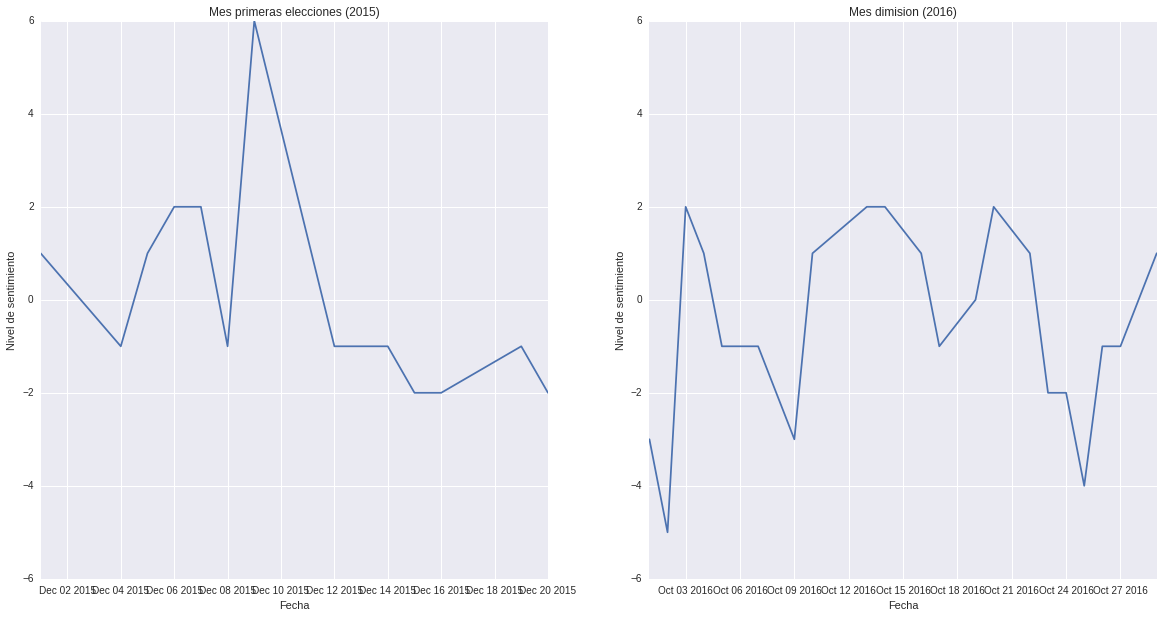

In [289]:
# Ponemos la fecha como índice:
tit2015_ps_final_plot = tit2015_ps_final.groupby(['Fecha'])['Indice_Sentimiento'].sum()
tit2015_ps_final_plot = pd.DataFrame(tit2015_ps_final_plot)
tit2015_ps_final_plot.head(5)

tit2016_ps_final_plot = tit2016_ps_final.groupby(['Fecha'])['Indice_Sentimiento'].sum()
tit2016_ps_final_plot = pd.DataFrame(tit2016_ps_final_plot)
tit2016_ps_final_plot.head(5)

# Ploteamos los resultados
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.xlabel('Fecha')
plt.ylabel('Nivel de sentimiento')
ylim([-6,6])
plt.title('Mes primeras elecciones (2015)')
plt.plot(tit2015_ps_final_plot['Indice_Sentimiento'])

plt.subplot(122)
plt.title('Mes dimision (2016)')
plt.xlabel('Fecha')
plt.ylabel('Nivel de sentimiento')
ylim([-6,6])
plt.plot(tit2016_ps_final_plot['Indice_Sentimiento'])

plt.show()

In [292]:
print 'Media del índice de sentimiento en diciembre 2015:', np.mean(tit2015_ps_final_plot['Indice_Sentimiento'])
print 'Media del índice de sentimiento en octubre 2016:', np.mean(tit2016_ps_final_plot['Indice_Sentimiento'])

Media del índice de sentimiento en diciembre 2015: 0.0769230769231
Media del índice de sentimiento en octubre 2016: -0.52380952381


#### Conclusión

En las gráficas finales podemos apreciar cómo, antes de las primeras elecciones (celebradas en diciembre de 2015), los titulares que aparecían en El País eran más benévolos con Pedro Sánchez de lo que lo fueron el mes anterior a su dimisión como secretario general.

Esto se aprecia mejor en la media del análisis de sentimiento realizado en los 2 períodos. En las primeras elecciones, las noticias positivas y negativas entorno a Pedro Sánchez y el PSOE se compensaban, quedando un sesgo casi neutral. Sin embargo, en el mes de octubre de 2016, eran más los titulares negativos aparecidos en El País, posicionándose en contra de Pedro Sánchez y el PSOE.

__Nota: debemos tener en cuenta que el modelo de predicción no es fiable al 100% y que el corpus está compuesto de tweets que no son exactamente lo mismo que un titular de un periódico__